# Draft data processing

## To do

 - [ ] Clean trajectories (How?). Iterpolation, remove outliers (e.g. points outside path)
 - [ ] Calculate speed for every 1/3 second or something instead of frame-to-frame? It seems like there is a lot of noise (super high speeds), which could be due do video clitches.
 - [x] Anotate video with CSV code. This could be usefull to troubleshoot data.
 

### To do video processing:
 - [ ] Drop tracking if they move out of defined filed of view area. This would solve more or less the issue with tracking different objects as the same

### To do cleaning
- [ ] If a trajectory goes and comes back, split into 2
- [ ] Filter out short trajectories
- [ ] Interpolate frames without tracking if trajectory is monotonic

### To do analysis
 - [ ] Only in trajectory if of a certain class
 - [ ] Intersections

## Settings

In [1]:
import cv2
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import plotly.express as px
from tqdm import tqdm

import os
import copy as cp

In [2]:
# Import custom functions 
# from utils import *

from modules.utils import *
from modules.draw import *
from modules.homography import PixelMapper

In [3]:

# PLotting params
plt.rcParams['figure.figsize'] = [15, 10]

# Printing params
pd.set_option("max_rows", 1000)


Functions (move this somewhere else eventually)

In [4]:
# Plot inline function for one ore two images
def imgshow(img, img2 = None):
    if img2 is None:
        plt.imshow(img)
        # plt.title('World view')
        plt.show()
    else:
        plt.subplot(1, 2, 1)
        plt.imshow(img)


        plt.subplot(1, 2, 2)
        plt.imshow(img2)

        plt.tight_layout()

        plt.show()

        
# Homography plot functions
def draw_point(img, point, color, label = None):
    img_cp = cp.deepcopy(img)
    pcoords = tuple(point)
    cv2.circle(img_cp, pcoords, 4, color, -1)
    if label is not None:
        tcoords = tuple(point + 5)
        cv2.putText(img_cp, label, tcoords,  cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)
    # ishow(img_cp)
    return img_cp


def draw_hom_points(img, points_array, label = True):
    """
    Plots all points in an array in a given image
    """
    
    img_cp = cp.deepcopy(img)
    # Loop over points
    i = 0
    for p in points_array:
        i += 1
        if label:
            label = 'p' + str(i)
        else:
            label = None
        img_cp = draw_point(img_cp, p, (0, 0, 255), label)
    return img_cp


# Draw movements trajectories
def draw_trajectory(img, trajectory_array, color):
    img_cp = cp.deepcopy(img)
    for p in range(1, len(trajectory_array)):
            cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
    return img_cp


# Plot areas function
def plot_polygon(*polygons, image, color =(0,255,255), alpha = 0.3, show = True):
    """
    Takes N polygon arrays and plots them on a given image
    """
    
    overlay = cp.deepcopy(image)
    image_new = cp.deepcopy(image)

    for poly in polygons:
        poly_i = cv2.fillPoly(overlay, pts = [poly], color = color)

    image_new = cv2.addWeighted(overlay, alpha, image_new, 1 - alpha, 0)
    
    if show:
        imgshow(image_new)
    else:
        return image_new


In [5]:
# Filter points from df if in area. Returns a boolean pandas series 
def points_in_area(points_df, area):
    df_dict = points_df[['cx', 'cy']].to_dict('records')
    
    # Empty list to store results
    bol_field_of_view = []
    
    # Loop over all points in df
    for row in tqdm(df_dict):
        # Test if point in area
        p_i = tuple([row['cx'], row['cy']])
        bol_int_i = cv2.pointPolygonTest(area, p_i, False)

        # Convert to boolean (Gambiarra)
        if bol_int_i == -1:
            bol_i = False
        else:
            bol_i = True

        bol_field_of_view.append(bol_i)
    
    return pd.Series(bol_field_of_view)





## Load data

Load tabular data outputed by video-processing model

In [6]:
os.listdir('data')

['2-frame.jpg', '2-sample-30min.csv', '2-sample-30min.mp4', '2-sat.jpg']

In [7]:
df = pd.read_csv('data/2-sample-30min.csv')

# Calculate centroids
df['cx'] =  round(df['xi'] + (df['xj'] - df['xi'])/2).astype(int)
df['cy'] =  round(df['yi'] + (df['yj'] - df['yi'])/2).astype(int)


Load images data

In [8]:
img_frame = cv2.imread('data/2-frame.jpg')
img_world = cv2.imread('data/2-sat.jpg')


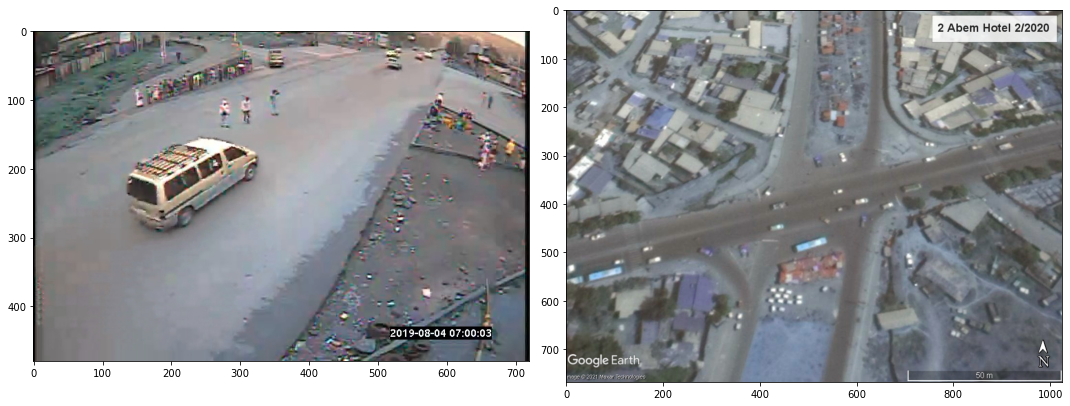

In [9]:
imgshow(img_frame, img_world)

In [10]:
img_frame.shape

(480, 720, 3)

## Homography

Homography points defintion: Set the same points in both images and coordinates

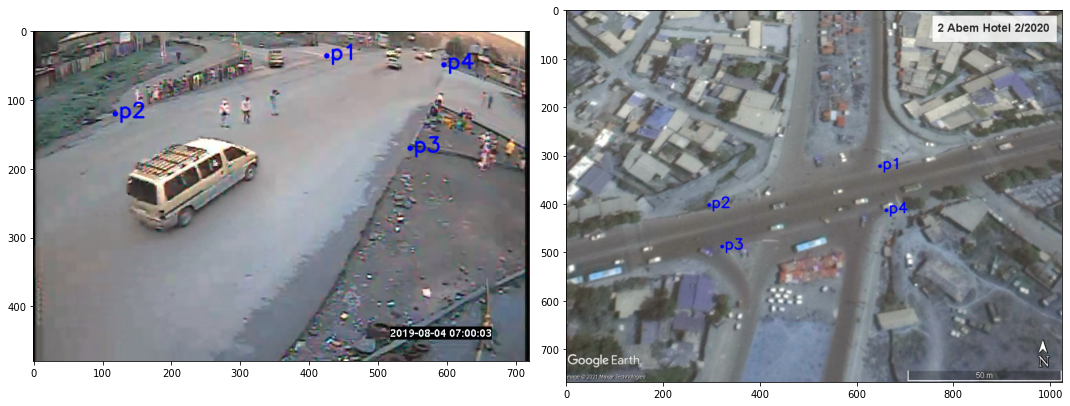

In [11]:
# Create one instance of PixelMapper to convert video frames to coordinates
quad_coords = {
#     # Unprojected
#     "lonlat": np.array([
#         [9.035947, 38.853956], # P1 top right
#         [9.035794, 38.853338], # P2 top left
#         [9.035631, 38.853425], # P3 bottom left
#         [9.035782, 38.853971] #  P4 bottom right
#     ]),
    # UTM
    "lonlat": np.array([
        [998829.59, 483949.29], # P1 top right
        [998812.71, 483881.37], # P2 top left
        [998794.68, 483890.92], # P3 bottom left
        [998811.35, 483950.93] #  P4 bottom right
    ]),
    "pixel": np.array([
        [426, 37], #  P1 top right
        [119, 121], #  P2 top left
        [547, 171], # P3 bottom left
        [596, 50] # P4 bottom right
    ]),
    "pixel_sat": np.array([
        [648, 322], # P1 top right
        [295, 402], # P2 top left
        [322, 488], #  P3 bottom left
        [661, 413] # P4 bottom right
    ])
}

# Display image points. 
img_s_points = draw_hom_points(img_world, quad_coords['pixel_sat'])
img_f_points = draw_hom_points(img_frame, quad_coords['pixel'])
imgshow(img_f_points, img_s_points)

PixelMapper class converts coordinates in pixels to lat-long

In [12]:
# Create pixel maper instance to convert from video to lat long (and vice versa)
pm = PixelMapper(quad_coords["pixel"], quad_coords["lonlat"])

# Create pixel maper instance to convert from sat image to lat long (and vice versa)
pm_sat = PixelMapper(quad_coords["pixel_sat"], quad_coords["lonlat"])

Test trajectory to see if homography is working:

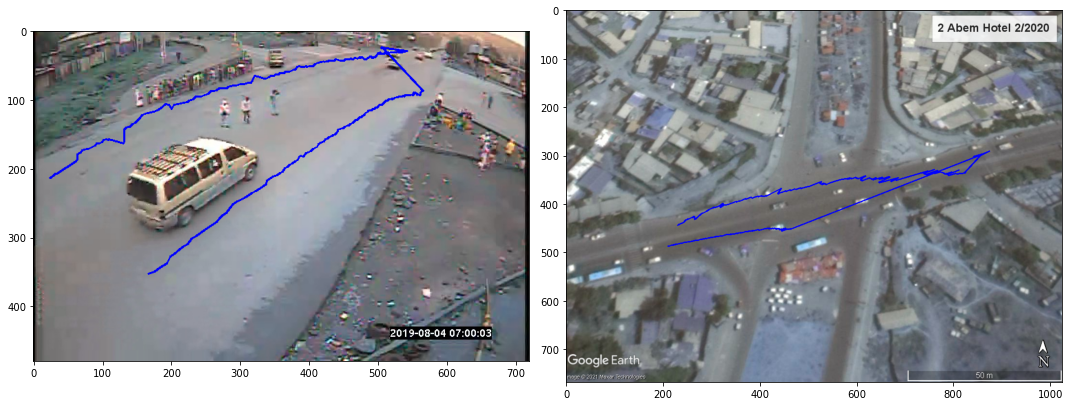

In [13]:
# To do
# - Make sure trajectories are in frame order
# - Organize this into a function






# Create trajectory df
car_df = df[df['obj_id'] == 197]

t_car = car_df[['cx', 'cy']].to_numpy()

# Anotate trajectory on initial video frame
img_cf = img_frame.copy()
img_cf = draw_trajectory(img_cf, t_car, (0, 0, 255))

# # ishow(img_cf)

# Transform trajectories to long lat
t_car_ll = pm.pixel_to_lonlat(t_car) # t_car created in draft-intersections.py

# Transform lat long trajectory into pixels of sat image
t_car_s = pm_sat.lonlat_to_pixel(t_car_ll).astype(int)

# # Anotate trajectory on sat image
img_cs = img_world.copy()
img_cs = draw_trajectory(img_cs, t_car_s, (0, 0, 255))

imgshow(img_cf, img_cs)

In [14]:
car_df

frame   xi   yi   xj   yj  obj_id  class   cx   cy
6713     610   63  259  271  447     197      2  167  353
6727     611   72  256  279  444     197      2  176  350
6741     612   80  251  287  438     197      2  184  344
6755     613   92  246  295  431     197      2  194  338
6770     614  102  240  296  417     197      2  199  328
6783     615  108  235  302  412     197      2  205  324
6796     616  116  231  307  406     197      2  212  318
6809     617  121  225  313  402     197      2  217  314
6821     618  131  223  318  396     197      2  224  310
6832     619  139  218  321  386     197      2  230  302
6845     620  150  217  324  378     197      2  237  298
6857     621  164  213  332  367     197      2  248  290
6868     622  170  209  339  363     197      2  254  286
6880     623  175  205  344  359     197      2  260  282
6891     624  184  204  347  351     197      2  266  278
6902     625  191  200  351  344     197      2  271  272
6914     626  196  197  354  339     197      2  275  268
6926     627  205  198  355  332     197      2  280  265
6939     628  211  189  362  325     197      2  286  257
6951     629  216  186  365  319     197      2  290  252
6962     630  222  183  370  314     197      2  296  248
6975     631  228  181  374  310     197      2  301  246
6988     632  236  180  379  304     197      2  308  242
7003     633  242  178  384  300     197      2  313  239
7018     634  247  177  387  296     197      2  317  236
7032     635  254  174  392  292     197      2  323  233
7046     636  261  172  396  287     197      2  328  230
7059     637  266  168  403  285     197      2  334  226
7072     638  271  166  404  280     197      2  338  223
7086     639  276  165  402  272     197      2  339  218
7100     640  281  164  402  267     197      2  342  216
7114     641  285  158  410  265     197      2  348  212
7128     642  292  157  416  263     197      2  354  210
7143     643  296  154  419  260     197      2  358  207
7158     644  302  153  423  257     197      2  362  205
7172     645  307  151  423  250     197      2  365  200
7184     646  312  150  426  247     197      2  369  198
7196     647  317  148  428  242     197      2  372  195
7209     648  321  146  432  240     197      2  376  193
7222     649  325  144  436  237     197      2  380  190
7236     650  329  141  440  235     197      2  384  188
7251     651  333  138  440  228     197      2  386  183
7266     652  334  137  441  226     197      2  388  182
7280     653  340  139  445  227     197      2  392  183
7295     654  342  134  449  223     197      2  396  178
7310     655  347  133  451  221     197      2  399  177
7322     656  352  132  454  218     197      2  403  175
7334     657  355  130  457  215     197      2  406  172
7349     658  360  129  459  212     197      2  410  170
7365     659  364  128  461  210     197      2  412  169
7381     660  366  125  462  205     197      2  414  165
7398     661  366  120  468  206     197      2  417  163
7412     662  369  120  469  204     197      2  419  162
7424     663  372  119  471  203     197      2  422  161
7436     664  378  119  471  198     197      2  424  158
7449     665  382  119  472  195     197      2  427  157
7462     666  385  118  473  192     197      2  429  155
7476     667  389  118  474  191     197      2  432  154
7490     668  391  117  476  189     197      2  434  153
7505     669  393  117  477  188     197      2  435  152
7519     670  397  116  480  186     197      2  438  151
7533     671  399  114  482  184     197      2  440  149
7547     672  403  113  481  178     197      2  442  146
7560     673  403  111  482  177     197      2  442  144
7573     674  406  110  485  176     197      2  446  143
7586     675  409  110  488  175     197      2  448  142
7599     676  412  110  489  173     197      2  450  142
7611     677  415  110  490  171     197      2  452  140
7624 

In [15]:
fig = px.scatter(car_df, x="cx", y="cy", text="frame", log_x=True, size_max=60)
fig.show()

## Frame definition

Set boundaries to exclude objects too far away from the camera since tracking tend to be less precise.

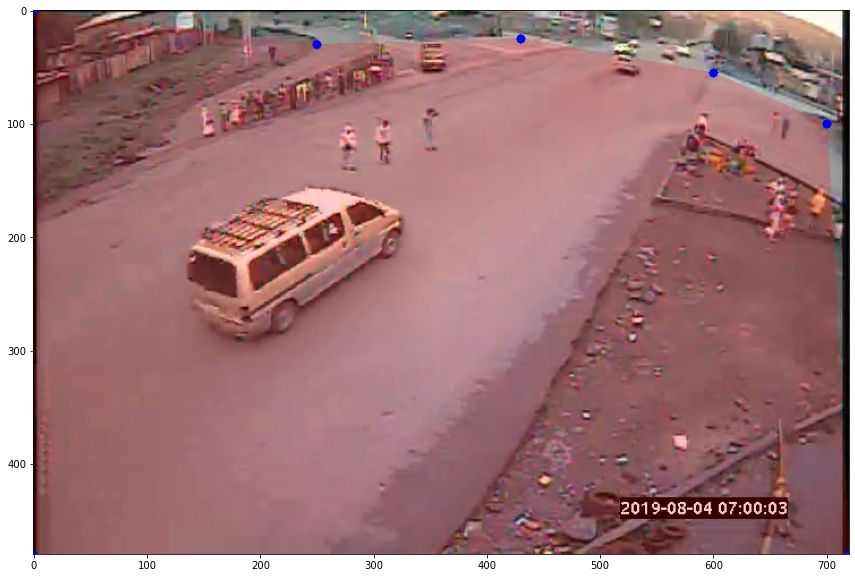

In [16]:
# Create new objects in memory
bound_overlay = cp.deepcopy(img_frame)
bound_image = cp.deepcopy(img_frame)



# Frame boundaries
boundaries = np.array([
    # Camera corners
    [0,0], # top left
    [0,img_frame.shape[0]], # bottom left
    [img_frame.shape[1],img_frame.shape[0]], # bottom right
    
    # Additional points to determine limits RIGHT to LEFT
    [700,100],
    [600,55],
    [430,25],
    [250,30],

    ]) 

alpha = 0.2  # Transparency factor.


# Camera field of view polygon
bound_poly = cv2.fillPoly(bound_overlay, pts = [boundaries], color =(255,0,0))


# PLot field of view
bound_image = cv2.addWeighted(bound_overlay, alpha, bound_image, 1 - alpha, 0)
bound_image = draw_hom_points(bound_image, boundaries, label = False)


imgshow(bound_image)



Filter data frame to only points within field of view

In [17]:
# Test each point individually. Try a more efficient way!

# image_new_cp = cp.deepcopy(bound_image)


# Supposedly the most efficient way of looping through a pandas df
df_dict = df.to_dict('records')


# Empty list to store results
bol_field_of_view = []

# Loop over all points in df
for row in tqdm(df_dict):
    # Test if point in area
    p_i = tuple([row['cx'], row['cy']])
    bol_int_i = cv2.pointPolygonTest(boundaries, p_i, False)
    
    # Convert to boolean (Gambiarra)
    if bol_int_i == -1:
        bol_i = False
    else:
        bol_i = True
    
    bol_field_of_view.append(bol_i)
#     print(bol_i)
#     cv2.circle(image_new_cp, tuple(p_i), radius=1, color=(0, 0, 255), thickness=3)    




100%|██████████████████████████████████████████████████████████████████████████| 592934/592934 [00:01<00:00, 427580.72it/s]


In [18]:


df[pd.Series(bol_field_of_view)].shape,  df.shape
# bool(bol_field_of_view)
# # bol_field_of_view
# type(bol_field_of_view)
# bol_field_of_view.astype('bool')

# bol_field_of_view

((447496, 9), (592934, 9))

In [19]:
371069/592934

0.6258183878812819

## Movements definitions

Define preliminary east and west through movement. For now, not making the distinction for direction for simplicity

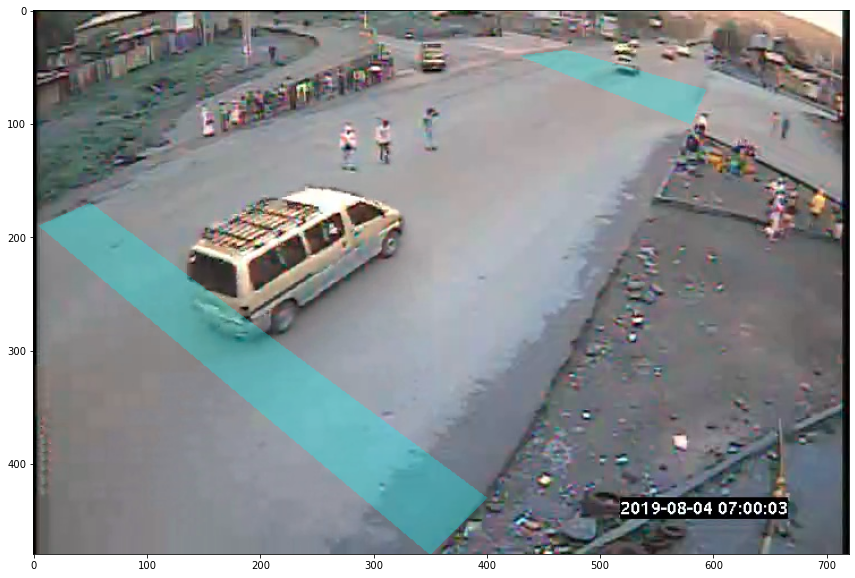

In [20]:
# First trajectory area
contours1 = np.array([[5,190], # top left 
                     [350,480], # bottom left
                     [400,430], # bottom right
                     [50,170]]) # top right
# Second trajectory area
contours2 = np.array([[430,40], # top left 
                     [580,100], # bottom left
                     [593,70], # bottom right
                     [470,35]]) # top right

plot_polygon(contours1, contours2, image = img_frame)

Define preliminary crossing pedestrians movement. Also not caring about order initially, but might increase precision to define multiple areas and define it as crossing any opposite pair in order.

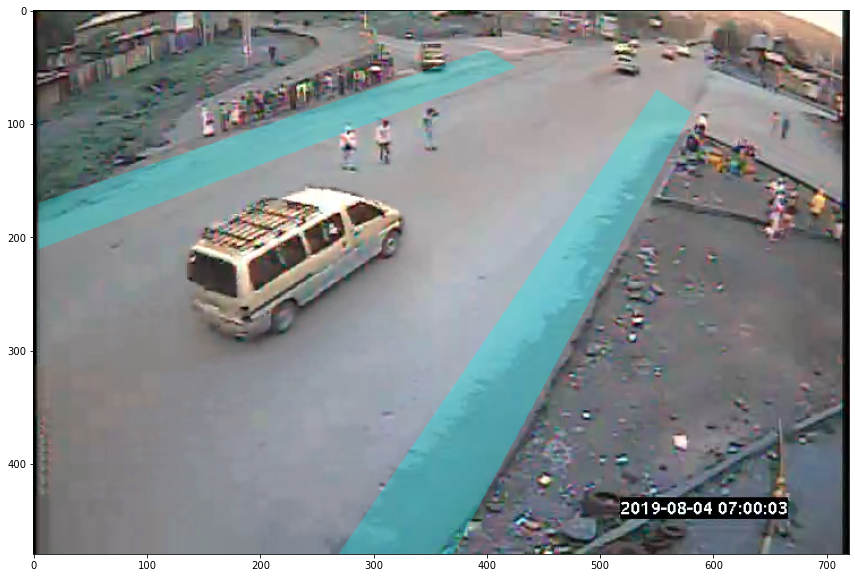

In [21]:


# First trajectory area
ped_area_1 = np.array([[5,170], # top left 
                       [400,35], # bottom left
                       [425,50], # bottom right
                       [5,210]]) # top right

# Second trajectory area
ped_area_2 = np.array([[270,480], # top left 
                         [550,70], # bottom left
                         [580,90], # bottom right
                         [370,480]]) # top right

plot_polygon(ped_area_1, ped_area_2, image = img_frame)    


# foo = plot_polygon(ped_area_1, ped_area_2, image = img_frame , show = False)
# foo = draw_hom_points(foo,ped_area_2)
# imgshow(foo)


Filter only trajectories that match the movement (o try to)

In [22]:
# Test trajectory

trj_temp = df[df['obj_id'] == 15]; trj_temp

p_temp = tuple(trj_temp.iloc[2][['cx','cy']]); p_temp

(472, 39)

Test if any points in the trajectory are in the defined areas. Idea is that if there are points in both, that trajectory is part of a pre defined movement.

In [23]:

# Copy image to anotate with trajectory
image_new_cp = cp.deepcopy(img_frame)

# Test each point individually. Try a more efficient way!


bol_area1 = []
bol_area2 = []

for i in range(0, len(trj_temp)):
    p_i = tuple(trj_temp.iloc[i][['cx', 'cy']])
    
    # Test if points in area
    bol_area1.append(cv2.pointPolygonTest(contours1, p_i, False))
    bol_area2.append(cv2.pointPolygonTest(contours2, p_i, False))

    cv2.circle(image_new_cp, tuple(p_i), radius=1, color=(0, 0, 255), thickness=3)
#     print(p_i)
#     print(bol)

# Test if any point in area
any(bol_area1)

any(bol_area2)

True

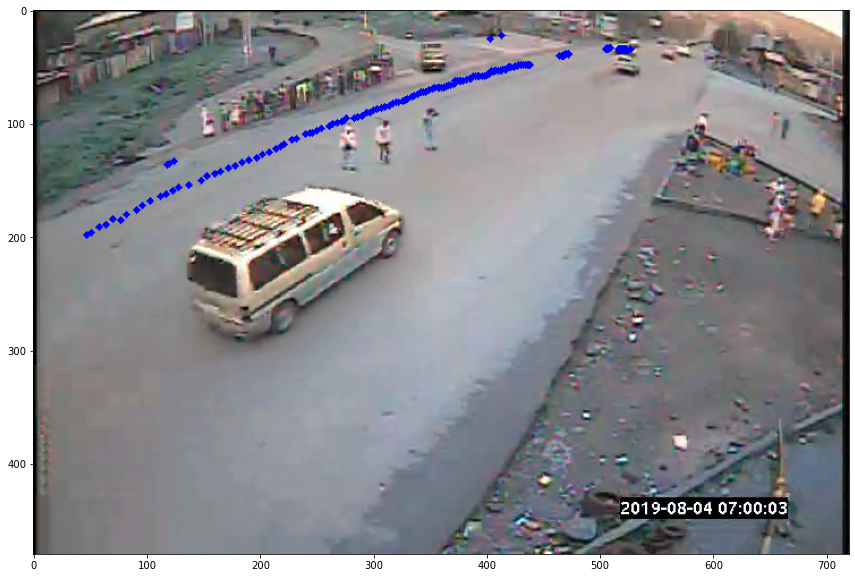

In [24]:
imgshow(image_new_cp)


# Filter trajectories

In [25]:
# df[points_in_area(df, ped_area_1)].shape[0]/df.shape[0]

def filter_by_movement(area1, area2, df):
    """
    Filter data frame by trajectories that are part of a movement. Defined by 
    having a at lease one point in both areas.
    """
    
    # Bool columns
    df['area1'] = points_in_area(df, area1)
    df['area2'] = points_in_area(df, area2)

    
    # Get ids of movements
    df_agg = df\
        .groupby('obj_id')\
        .agg({'area1' : any, 'area2' : any})
    
    trajectories_in_movement = df_agg[df_agg['area1'] & df_agg['area2']].index
    
    return df[df['obj_id'].isin(trajectories_in_movement)]


mov1 = filter_by_movement(ped_area_1, ped_area_2, df)
mov2 = filter_by_movement(contours1, contours2, df)



100%|██████████████████████████████████████████████████████████████████████████| 592934/592934 [00:01<00:00, 581339.65it/s]


In [48]:
# mov1['obj_id'].unique()
# mov2['obj_id'].unique()
mov1

frame   xi   yi   xj   yj  obj_id  class   cx   cy  area1  area2
65          7  573   70  583   87      16      0  578   78  False  False
76          8  572   70  583   86      16      0  578   78  False  False
88          9  572   70  583   86      16      0  578   78  False  False
100        10  572   70  583   86      16      0  578   78  False  False
111        11  572   70  583   86      16      0  578   78  False  False
...       ...  ...  ...  ...  ...     ...    ...  ...  ...    ...    ...
591000  53792  648  169  668  214   15458      0  658  192  False  False
591014  53793  649  170  669  213   15458      0  659  192  False  False
591027  53794  651  170  670  212   15458      0  660  191  False  False
591061  53797  650  169  674  222   15458      0  662  196  False  False
591073  53798  650  169  675  222   15458      0  662  196  False  False

[52358 rows x 11 columns]

In [55]:

# Get one points
# p1 = mov1.iloc[0][['cx', 'cy']].to_numpy()

points_trajectory = mov1[mov1['obj_id'] == 16][['cx', 'cy']].to_numpy()

p1 = points_trajectory[0]



# test if there are intersections with a trajectory
trajectory_1 = mov2[mov2['obj_id'] == 15][['cx', 'cy']].to_numpy()
# trajectory_1

mask = np.isin(b1, trajectory_1)
np.all(mask, axis=1)


In [82]:
# points_trajectory = mov1[mov1['obj_id'] == 16][['cx', 'cy']].to_numpy()
points_trajectory = mov1[mov1['obj_id'] == 53][['cx', 'cy']].to_numpy()


trajectory_1 = mov2[mov2['obj_id'] == 15][['cx', 'cy']].to_numpy()



# def trajectory_intersection(trj1, traj2):
    
#     # Create a 1 pixel buffer around it
#     buffer_array = [[1,1],
#                     [0,1],
#                     [1,0],
#                     [-1,0],
#                     [0,-1],
#                     [-1,1],
#                     [1,-1],
#                     [-1,1]]
    
#     # Loop through points to test if intersection
#     for p in points_trajectory:
        
#         b = p + buffer_array
        
#         mask = np.isin(b1, trajectory_1)
#         np.all(mask, axis=1)
        
        
#     return 

In [81]:
mov1['obj_id'].unique()

array([   16,    53,   143,   197,   454,   493,   708,   791,   923,
        1013,  1313,  1538,  1854,  2075,  2196,  2300,  2310,  2653,
        3055,  3253,  3598,  4054,  4099,  4228,  4453,  4508,  4516,
        4681,  4796,  4916,  5335,  5396,  5621,  5895,  6044,  6980,
        7014,  7239,  7367,  7646,  7767,  8020,  8095,  8284,  8301,
        8655,  8737,  9012,  9161,  9274,  9534,  9559,  9665,  9907,
        9921, 10108, 10261, 10263, 10431, 10874, 10906, 11132, 11486,
       11608, 12352, 12494, 12968, 13066, 13129, 13142, 13298, 13347,
       13490, 13653, 13669, 13811, 13944, 14009, 14287, 14662, 15038,
       15104, 15168, 15242, 15458], dtype=int64)

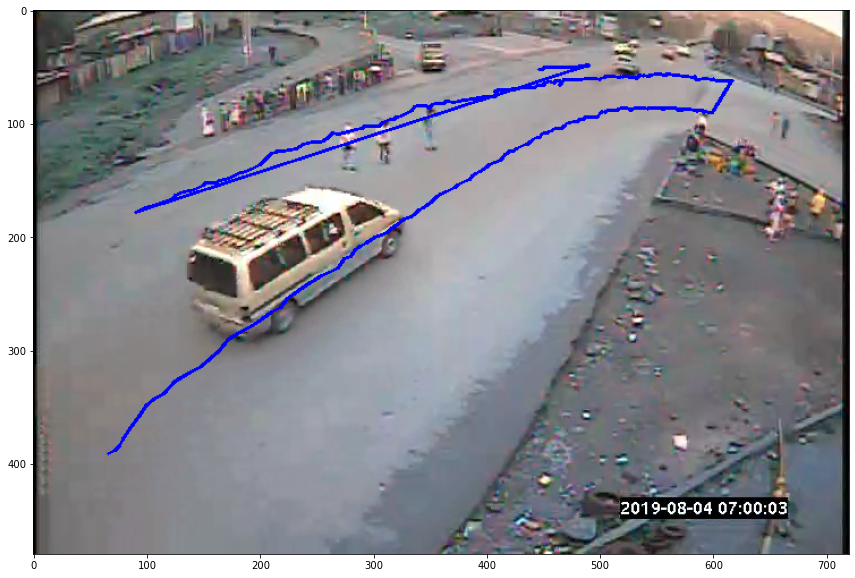

In [83]:
# Draw movements trajectories
def draw_trajectory(img, trajectory_array, color = (0, 0, 255), show = True):
    img_cp = cp.deepcopy(img)
    for p in range(1, len(trajectory_array)):
            cv2.line(img_cp, tuple(trajectory_array[p-1]), tuple(trajectory_array[p]), color, 2)
    if show:
        imgshow(img_cp)
    else:
        return img_cp

draw_trajectory(img_frame, points_trajectory)

##  Calculate point speed

In [ ]:
# Test distance between reference points to see if consistent

In [ ]:
quad_coords['lonlat'][0]

In [54]:
quad_coords['lonlat'][1]

array([998812.71, 483881.37])

In [ ]:
998829.59-998812.71

In [ ]:

# math.dist(quad_coords['lonlat'][0], quad_coords['lonlat'][1])

# quad_coords['lonlat'][0] - quad_coords['lonlat'][1]
np.linalg.norm(quad_coords['lonlat'][0] - quad_coords['lonlat'][1])


In [ ]:
# Create trajectory df
trj_temp = df[df['obj_id'].isin([1,15])]
# trj_temp = df.copy()

# trj_temp = df[df['obj_id'].isin([15])]


t_temp = trj_temp[['cx', 'cy']].to_numpy()


# # ishow(img_cf)

# Transform trajectories to long lat
t_temp_ll = pm.pixel_to_lonlat(t_temp) # t_car created in draft-intersections.py

In [ ]:
foo = pd.DataFrame(t_temp_ll)
foo.columns = ['c_lat', 'c_long']
# foo

In [ ]:
new_df = pd.concat([trj_temp.reset_index(drop=True), foo.reset_index(drop=True)], axis=1)
new_df = new_df.sort_values(['obj_id', 'frame'])

In [ ]:
# lag variable
# shifted = new_df.groupby("obj_id") #.shift(1) 
# shifted = new_df.shift(1)[['frame', 'obj_id', 'c_lat', 'c_long']]


new_df['c_lat_l'] = new_df.groupby(['obj_id'])['c_lat'].shift(1)
new_df['c_long_l'] = new_df.groupby(['obj_id'])['c_long'].shift(1)

new_df


# df_new.join(shifted, rsuffix = '_l')
# new_df.shape

In [ ]:
# Calculate distance from point to point lag for the whole data

from scipy.spatial.distance import cdist

foo = cdist(new_df[['c_lat', 'c_long']], new_df[['c_lat_l', 'c_long_l']], 'euclid')
new_df['dist_m'] = np.diagonal(foo)

new_df

In [ ]:


# Calculate speed
fps = 30

new_df['speed_ms'] = new_df['dist_m']/(1/fps)
new_df['speed_kmh'] = new_df['speed_ms']*3.6
new_df[['frame', 'obj_id', 'cx', 'cy', 'c_lat','c_long', 'c_lat_l', 'c_long_l','dist_m', 'speed_ms','speed_kmh']]




In [ ]:
new_df.columns

In [ ]:
# Comaparing two functions
# np.linalg.norm(np.array([998792.072463,483877.645084]) - np.array([998792.089436, 483877.619475]))

In [ ]:
t_temp_ll.shape

In [ ]:
trj_temp

# DRAFT

In [ ]:
#----------------------------------------------------
# Use mouse to find points (or try to at least)


# Marker and grab position function

img = cp.deepcopy(img_frame)
mouseX,mouseY = 0,0

def draw_circle(event,x,y,flags,param):
    global mouseX,mouseY
    if event == cv2.EVENT_LBUTTONDOWN:
        cv2.circle(img,(x,y),3,(255,0,0),1)
        mouseX,mouseY = x,y
        

# A window that will capture the mouse click
# cv2.namedWindow('image')
# cv2.setMouseCallback('image', draw_circle)

# while(1):
#     cv2.imshow('image',img)
#     # Kill window if Q is pressed
#     k = cv2.waitKey(1) & 0xFF
#     if k == ord('q'):
#         cv2.destroyAllWindows()
#         break
#     elif k == ord('a'):
#         print(mouseX,mouseY)
# print(mouseX,mouseY)

In [ ]:
cv2.destroyAllWindows()